# Setup

In [1]:
!nvidia-smi

Sat May  3 15:56:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics

# Install YOLOv8

In [3]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo checks

Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)

OS                  Linux-6.1.123+-x86_64-with-glibc2.35
Environment         Colab
Python              3.11.12
Install             pip
Path                /usr/local/lib/python3.11/dist-packages/ultralytics
RAM                 12.67 GB
Disk                41.4/112.6 GB
CPU                 Intel Xeon 2.30GHz
CPU count           2
GPU                 Tesla T4, 15095MiB
GPU count           1
CUDA                12.4

numpy               ✅ 2.0.2>=1.23.0
matplotlib          ✅ 3.10.0>=3.3.0
opencv-python       ✅ 4.11.0.86>=4.6.0
pillow              ✅ 11.2.1>=7.1.2
pyyaml              ✅ 6.0.2>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.15.2>=1.4.1
torch               ✅ 2.6.0+cu124>=1.8.0
torch               ✅ 2.6.0+cu124!=2.4.0,>=1.8.0; sys_platform == "win32"
torchvision         ✅ 0.21.0+cu124>=0.9.0
tqdm                ✅ 4.67.

# Train YOLO model

Train and Val data

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Fc2gbaeaxXQcNi4deZho")
project = rf.workspace("fyp-79hef").project("detection-of-emotion")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


Test data

In [5]:
import os
import random
import shutil

# Paths
val_images_path = f"{dataset.location}/valid/images"
val_labels_path = f"{dataset.location}/valid/labels"
test_images_path = f"{dataset.location}/test/images"
test_labels_path = f"{dataset.location}/test/labels"

# Create test folders
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Get list of images
val_images = os.listdir(val_images_path)
test_sample = random.sample(val_images, k=int(0.2 * len(val_images)))  # 20% of val -> test

# Move images and labels
for img in test_sample:
    label = img.replace('.jpg', '.txt')
    shutil.move(os.path.join(val_images_path, img), os.path.join(test_images_path, img))
    shutil.move(os.path.join(val_labels_path, label), os.path.join(test_labels_path, label))

print(f"Moved {len(test_sample)} images to test set.")

Moved 13 images to test set.


In [8]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 \
augment=True hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 degrees=10 translate=0.1 scale=0.5 shear=2 perspective=0.001 flipud=0.5 fliplr=0.5

Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Detection-of-Emotion-4/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

# Confusion Matrix

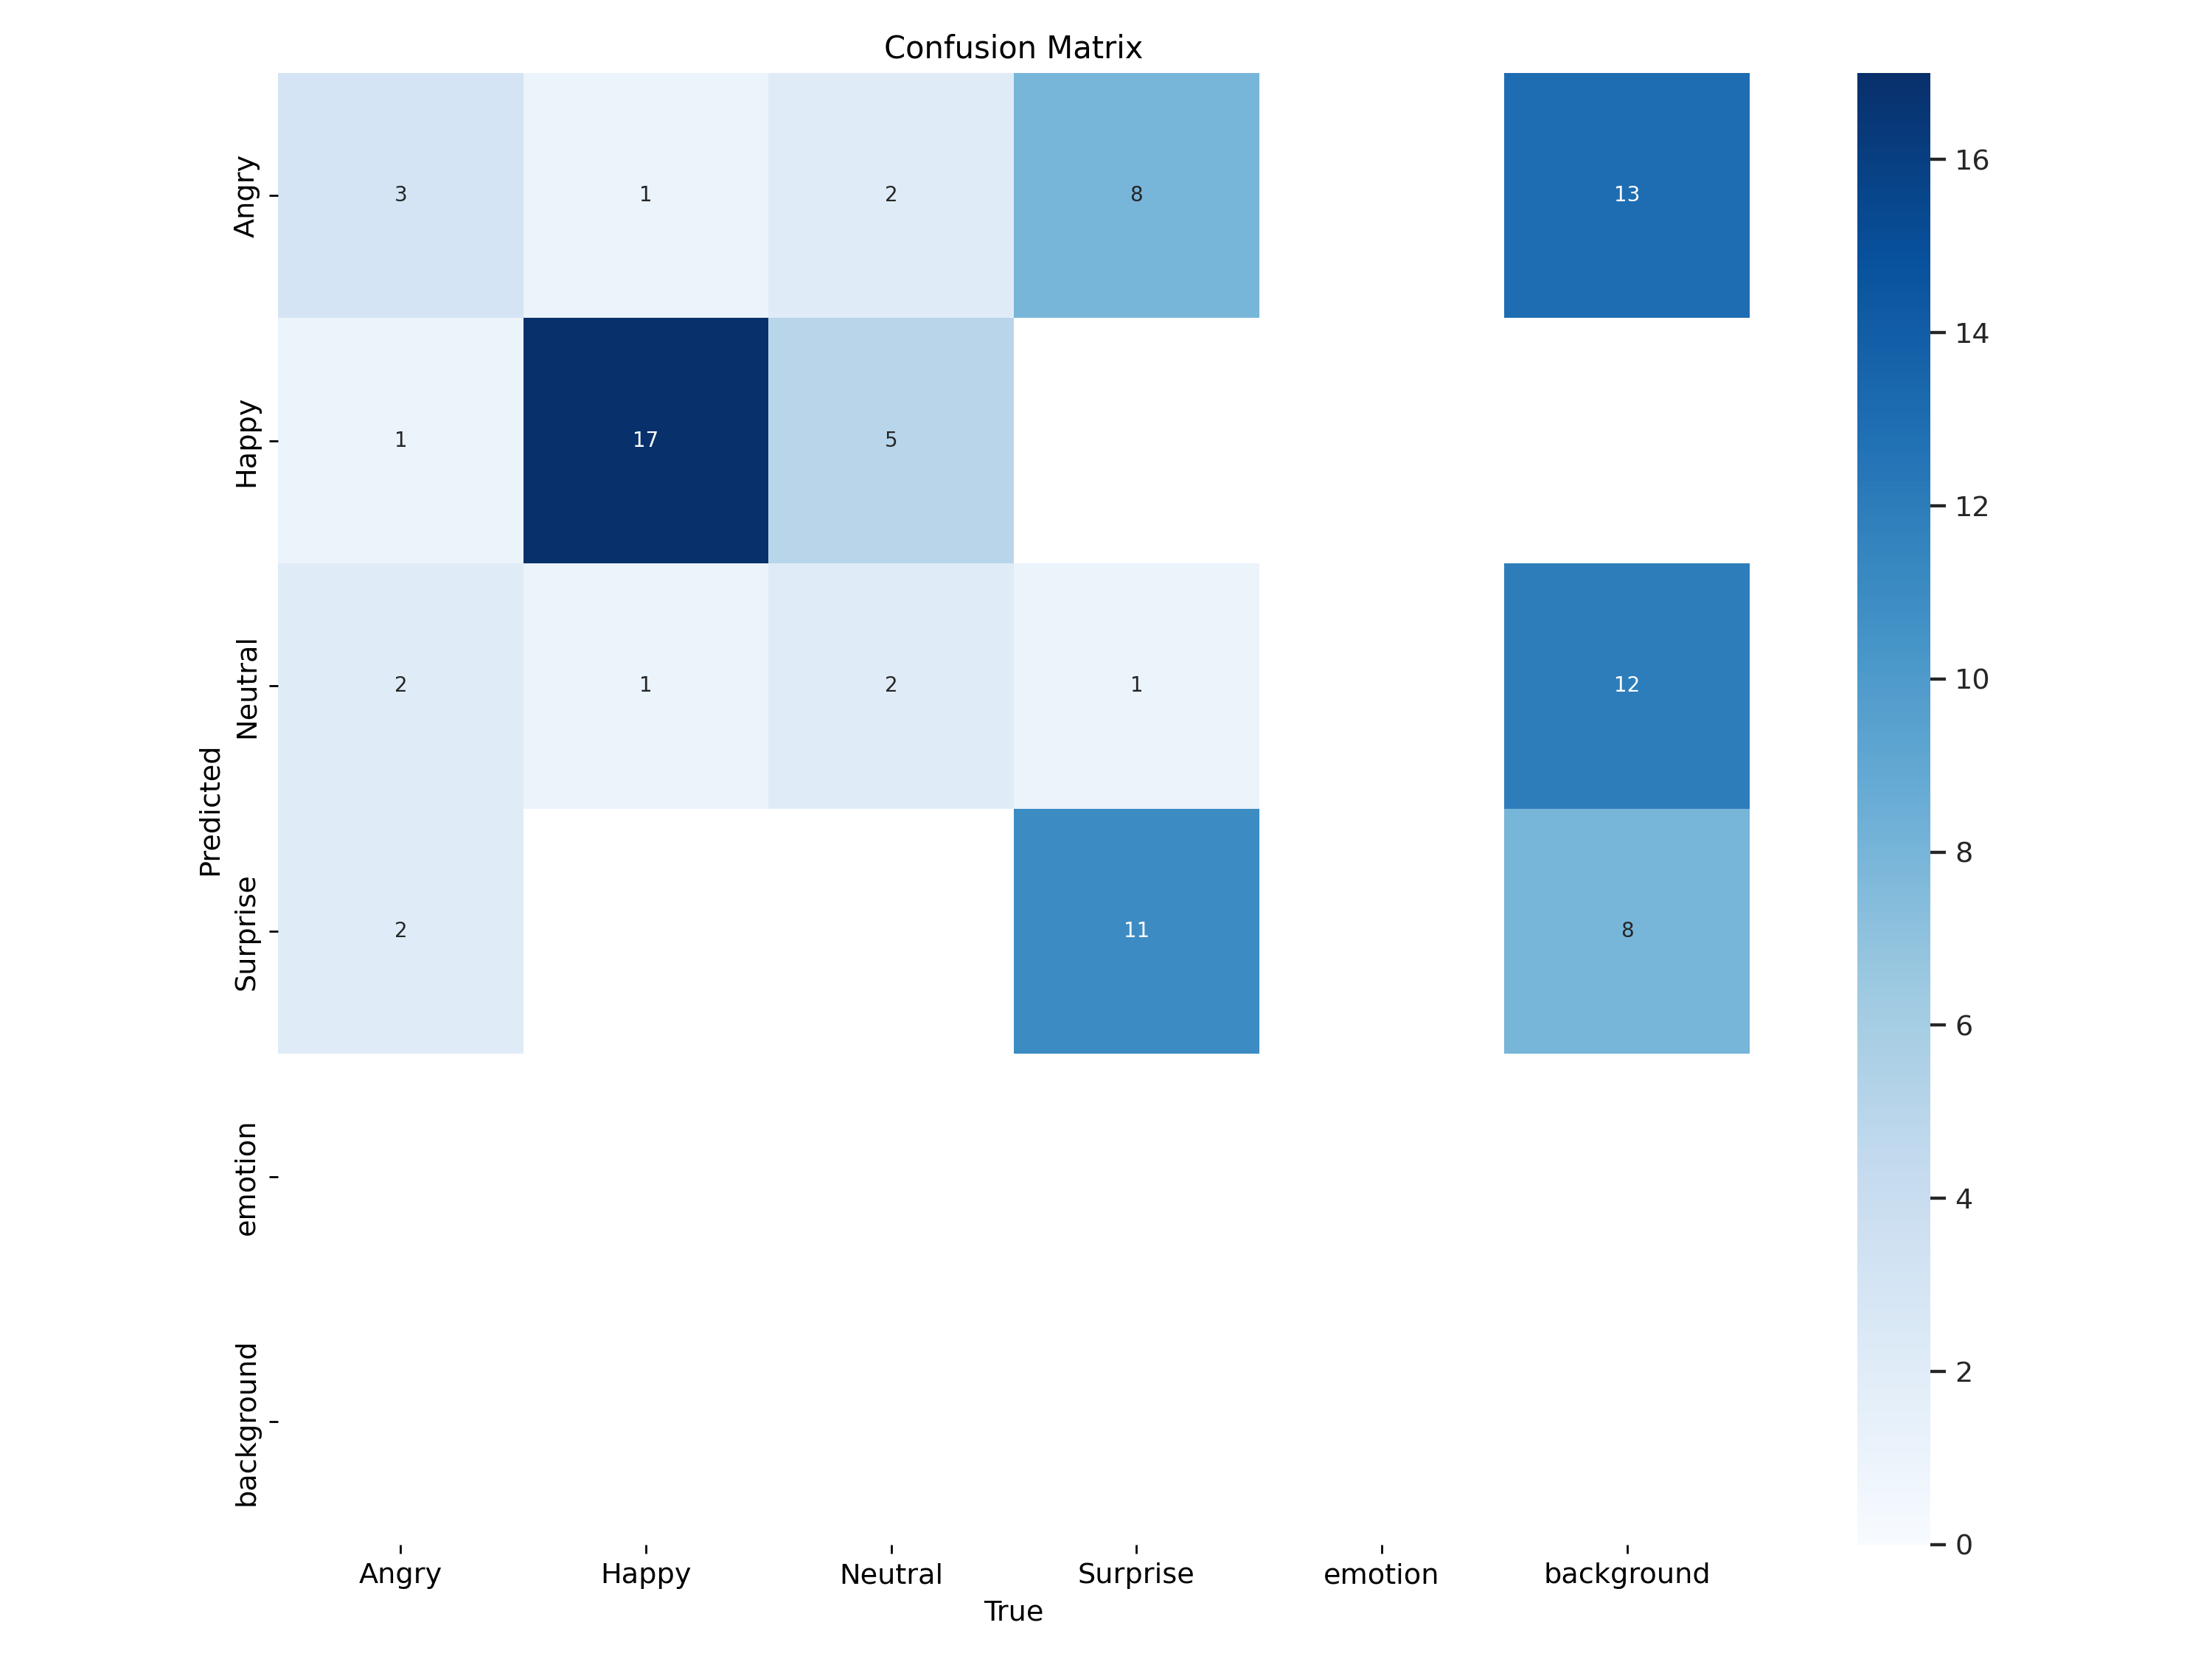

In [9]:
Image(filename=f'/content/runs/detect/train2/confusion_matrix.png', width=600)

# Train Results

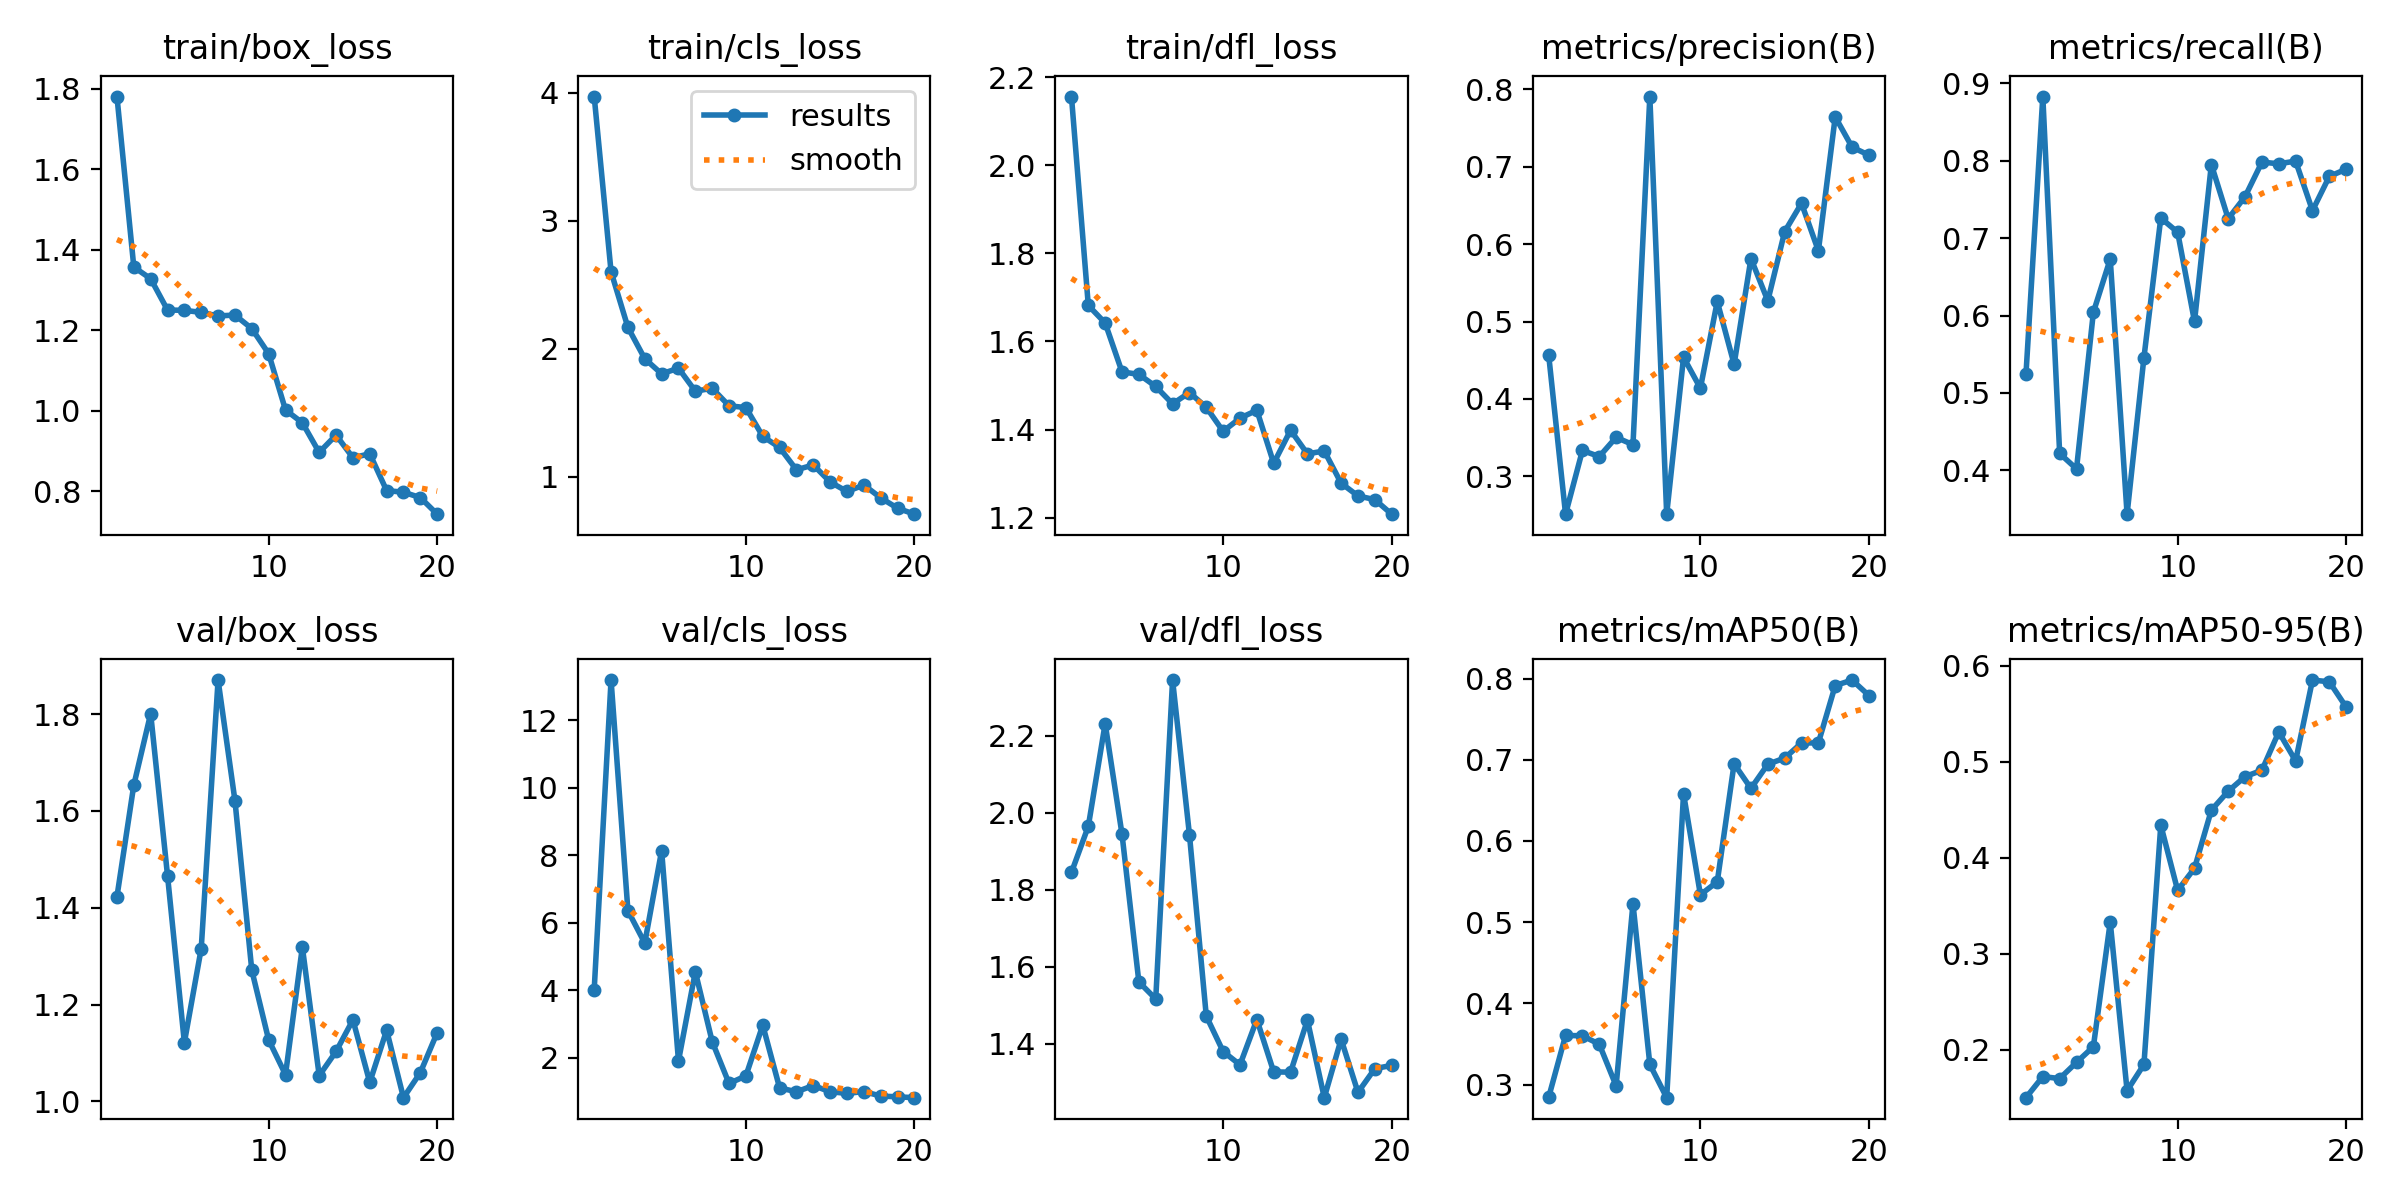

In [10]:
Image(filename=f'/content/runs/detect/train2/results.png', width=600)

# Validation

In [11]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 563.6±228.0 MB/s, size: 12.5 KB)
val: Scanning /content/Detection-of-Emotion-4/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100% 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:01<00:00,  2.04it/s]
                   all         56         56      0.653      0.796      0.721      0.529
                 Angry          8          8       0.45      0.616      0.341      0.206
                 Happy         19         19      0.749      0.941      0.939      0.704
               Neutral          9          9      0.551      0.778       0.63      0.501
              Surprise         20         20      0.862       0.85      0.973      0.705
Speed: 5.6ms preprocess, 14.4ms inference, 0.0ms l

# Testing

In [12]:
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt source={dataset.location}/test/images

Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs

image 1/30 /content/Detection-of-Emotion-4/test/images/Anger-29_jpg.rf.f75e8c470195bb6f0f39dc5b84da8427.jpg: 640x640 1 Neutral, 16.2ms
image 2/30 /content/Detection-of-Emotion-4/test/images/Anger-5_jpeg.rf.f6e790ac3b70be11bda2348af5a37b1b.jpg: 640x640 1 Angry, 1 Surprise, 16.3ms
image 3/30 /content/Detection-of-Emotion-4/test/images/Happy-23_jpg.rf.a1a5fbf40f3133187e7340abbaaae528.jpg: 640x640 1 Happy, 16.2ms
image 4/30 /content/Detection-of-Emotion-4/test/images/Happy-26_jpg.rf.bf9d5be5480fa67a545e355ac1f879fc.jpg: 640x640 1 Happy, 16.3ms
image 5/30 /content/Detection-of-Emotion-4/test/images/Happy-41_jpg.rf.dfb2e3022760f80c5be65646e6d162e5.jpg: 640x640 1 Happy, 16.2ms
image 6/30 /content/Detection-of-Emotion-4/test/images/Happy-58_jpeg.rf.be18aaaba800c622b92aedc60465cb42.jpg: 640x640 1 Neutral, 16.2ms
image 7/30 /content

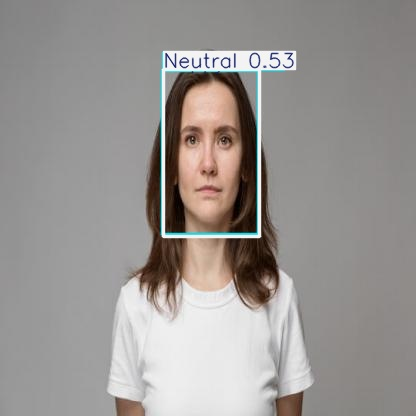

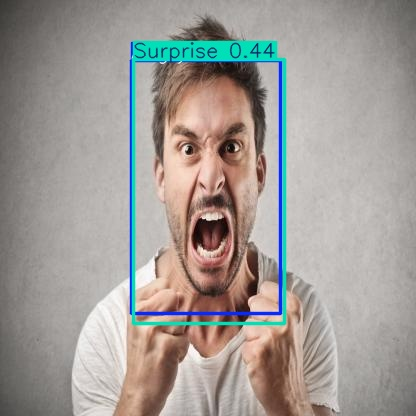

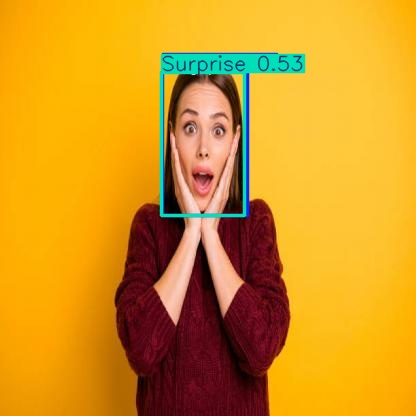

In [13]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('/content/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, height=300))
      print("\n")